In [1]:
import os
import typing
from dask_jobqueue import PBSCluster
from pathlib import Path

# Define the working directory path
working_directory = str(Path.cwd())

# Launch a scheduler and workers on HPC via PBS
cluster = PBSCluster(
     cores=4,
     memory="8GB",
     processes=1,
     queue="tamirQ",
     walltime="02:30:00",
     scheduler_options={"dashboard_address": ":12435"},  # FIXME - this is the port we need to define...
     # Additional custom options
     log_directory="dask-logs",
     #worker_extra_args=["--lifetime", "25m", "--lifetime-stagger", "4m"],  # for walltime="00:30:00"
     job_script_prologue=[f"cd {working_directory}"]
)
cluster
cluster.adapt(minimum=10, maximum=60)
print(cluster.job_script())
from dask.distributed import Client, progress, wait, get_client, get_worker
client = Client(cluster)
client

#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q tamirQ
#PBS -l select=1:ncpus=4:mem=7630MB
#PBS -l walltime=02:30:00
#PBS -e dask-logs/
#PBS -o dask-logs/
cd /tamir2/moranb/microbiome/Igem_TAU_2021
/tamir2/moranb/microbiome/Igem_TAU_2021/venv/bin/python -m distributed.cli.dask_worker tcp://132.66.112.146:44674 --nthreads 4 --memory-limit 7.45GiB --name dummy-name --nanny --death-timeout 60



Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://132.66.112.146:12435/status,
Dashboard: http://132.66.112.146:12435/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://132.66.112.146:44674,Workers: 0
Dashboard: http://132.66.112.146:12435/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [2]:
import dask.bag as db
import dask.dataframe as dd
from dask import delayed, compute, persist
from pandas.core.dtypes.common import pandas_dtype as dtype
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import seaborn as sns
import operator
from Bio import SeqIO, AlignIO
from analysis.input_testing_data.generate_input_testing_data_for_modules import generate_testing_data
from analysis.input_testing_data.generate_input_testing_data_for_modules import generate_testing_data_for_ecoli_and_bacillus

from modules.main import run_modules
from modules.user_IO.input_functions import extract_gene_data

In [3]:
output_path = "/tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/arabidopsis"
optimization_cub_index = "CAI"

variant_names = [
    "single_diff",
    "zscore_bulk_diff",
    "single_ratio",
    "zscore_bulk_ratio",
]
variant_scores_names = ["{score}_" + variant_name for variant_name in variant_names]

average_distance_score_variant_names = [s.format(score="average_distance_score") for s in variant_scores_names]
ratio_score_variant_names = [s.format(score="ratio_score") for s in variant_scores_names]

In [27]:
def get_orf_summary(summary: typing.Dict[str, typing.Any], evaluation_method: str = "average_distance_score") -> typing.Dict[str, typing.Any]:
    if len(summary["evaluation"]) == 1:
        return summary["orf"]
    final_evaluation = summary["final_evaluation"]
    for i, evaluation_summary in enumerate(summary["evaluation"]):
        if evaluation_summary[evaluation_method] == final_evaluation[evaluation_method]:
            return summary["orf"][i]

def get_total_run_time(summary: typing.Dict[str, typing.Any]) -> float:
     if len(summary["evaluation"]) == 1:
        return summary["orf"]["run_time"]
     run_time = 0
     for orf_summary in summary["orf"]:
         run_time += orf_summary["run_time"]
     return run_time

def extract_organism_name_from_path(organism_path):
    return organism_path.split("/")[-1].removesuffix(".gbff")

def extract_organism_names(organism_paths):
    if isinstance(organism_paths, str):
        return extract_organism_name_from_path(organism_paths)
    return "|".join([extract_organism_name_from_path(organism_path) for organism_path in organism_paths])
    
def convert_json(x):
    configuration = x["configuration"]
    result = x["result"]
    orf = get_orf_summary(result)
    if "orf" not in result or orf is None: # probably thrown in case of an error
        return {
            "error_message": result,
        }
    run_time = get_total_run_time(result)
    iterations_count = str(orf.get("iterations_count", 1))
    return {
        "wanted_organisms": extract_organism_names(configuration[0]),
        "unwanted_organisms": extract_organism_names(configuration[1]),
        "initial_optimization_score": orf.get("initial_sequence_optimization_score"),
        "final_optimization_score": orf.get("final_sequence_optimization_score"),
        "average_distance_score": result["final_evaluation"].get("average_distance_score"),
        "average_distance_non_normalized_score": result["final_evaluation"].get("average_distance_non_normalized_score"),
        "weakest_link_score": result["final_evaluation"].get("weakest_link_score"),
        "ratio_score": result["final_evaluation"].get("ratio_score"),
        "orf_optimization_cub_index": result["module_input"].get("orf_optimization_cub_index"),
        "evaluation_score": result["module_input"].get("evaluation_score"),
        "run_time": run_time,
        "iterations_count": iterations_count,
        "final_sequence": result["final_evaluation"].get("final_sequence"),
    }

def json_map(x):
    x = x.strip("\n")
    result = None
    try:
        result = json.loads(x)
        return convert_json(result)
    except Exception as e:
        return {"error_message": "bad json string: " + str(e), "input": x}

In [43]:
def get_df_for_run_configuration(configuration, optimization_method, is_debug=False):
    configuration_output_path = os.path.join(output_path, configuration)
    debug_suffix = '-debug' if is_debug else ''
    results_dir = F"{os.path.join(configuration_output_path, optimization_method + debug_suffix)}"
    print(f"results dir is: {results_dir}")
    file_names = [str(file) for file in list(Path(results_dir).rglob("*.json"))]
    bag = db.read_text(file_names).map(json_map)

    error_records = bag.filter(lambda x: "error_message" in x.keys())
    valid_records = bag.filter(lambda x: "error_message" not in x.keys())
    return valid_records.compute(), error_records.compute()
    return valid_records.to_dataframe().compute(), error_records.compute()

    # return dd.read_json([str(file) for file in list(Path(results_dir).rglob("*.json"))], orient='records', lines=True)
    
def get_scores_df_by_configuration_df(configuration, is_debug=False):
    df_bulk_zscore_ratio, df_bulk_zscore_ratio_errors = get_df_for_run_configuration(configuration, "zscore_bulk_aa_ratio", is_debug)
    df_bulk_zscore_diff, df_bulk_zscore_diff_errors = get_df_for_run_configuration(configuration, "zscore_bulk_aa_diff", is_debug)
    merged_bulk_zscore_df = dd.merge(df_bulk_zscore_ratio, df_bulk_zscore_diff, on=['wanted_organisms', 'unwanted_organisms'], how='inner', suffixes=('_zscore_bulk_ratio', '_zscore_bulk_diff'))

    # df_single_zscore_ratio, df_single_zscore_ratio_errors = get_df_for_run_configuration(configuration, "zscore_single_aa_ratio", is_debug)
    # df_single_zscore_diff, df_single_zscore_diff_errors = get_df_for_run_configuration(configuration, "zscore_single_aa_diff", is_debug)
    # merged_single_zscore_df = dd.merge(df_single_zscore_ratio, df_single_zscore_diff, on='gene_name', how='inner', suffixes=('_zscore_single_ratio', '_zscore_single_diff'))

    df_single_codon_ratio, df_single_codon_ratio_error = get_df_for_run_configuration(configuration, "single_codon_ratio", is_debug)
    df_single_codon_diff, df_single_codon_diff_error = get_df_for_run_configuration(configuration, "single_codon_diff", is_debug)
    merged_single_df = dd.merge(df_single_codon_ratio, df_single_codon_diff, on=['wanted_organisms', 'unwanted_organisms'], how='inner', suffixes=('_single_ratio', '_single_diff'))
    
    # merged_df = dd.merge(merged_bulk_zscore_df, merged_single_zscore_df, on='gene_name', how='inner')
    merged_df = dd.merge(merged_bulk_zscore_df, merged_single_df, on=['wanted_organisms', 'unwanted_organisms'], how='inner')
    
    df_single_wanted_organism, df_single_wanted_organism_error = get_df_for_run_configuration(configuration, "single_wanted_organism", is_debug)
    merged_df = dd.merge(merged_df, df_single_wanted_organism, on=['wanted_organisms', 'unwanted_organisms'], how='inner')

    merged_df = merged_df.rename(columns={
        'initial_optimization_score': 'initial_optimization_score_single_wanted_organism',
        'final_optimization_score': 'final_optimization_score_single_wanted_organism',
        'average_distance_score': 'average_distance_score_single_wanted_organism',
        'average_distance_non_normalized_score': 'average_distance_non_normalized_score_single_wanted_organism',
        'weakest_link_score': 'weakest_link_score_single_wanted_organism',
        'ratio_score': 'ratio_score_single_wanted_organism',
        'orf_optimization_cub_index': 'orf_optimization_cub_index_single_wanted_organism',
        'evaluation_score': 'evaluation_score_single_wanted_organism',
        'run_time': 'run_time_single_wanted_organism',
        'iterations_count': 'iterations_count_single_wanted_organism',
        'final_sequence': 'final_sequence_single_wanted_organism',
    })
    
    return merged_df, [
        df_bulk_zscore_ratio_errors,
        df_bulk_zscore_diff_errors, 
        # df_single_zscore_ratio_errors, 
        # df_single_zscore_diff_errors, 
        df_single_codon_ratio_error,
        df_single_codon_diff_error,
        df_single_wanted_organism_error,
    ]

In [6]:
def get_scores_df_by_configuration(configuration, is_debug=False):
    df_bulk_zscore_ratio, df_bulk_zscore_ratio_errors = get_df_for_run_configuration(configuration, "zscore_bulk_aa_ratio", is_debug)
    df_bulk_zscore_diff, df_bulk_zscore_diff_errors = get_df_for_run_configuration(configuration, "zscore_bulk_aa_diff", is_debug)

    df_single_codon_ratio, df_single_codon_ratio_error = get_df_for_run_configuration(configuration, "single_codon_ratio", is_debug)
    df_single_codon_diff, df_single_codon_diff_error = get_df_for_run_configuration(configuration, "single_codon_diff", is_debug)

    return [
        df_bulk_zscore_ratio,
        df_bulk_zscore_diff,
        df_single_codon_ratio,
        df_single_codon_diff,
    ], [
        df_bulk_zscore_ratio_errors,
        df_bulk_zscore_diff_errors, 
        df_single_zscore_ratio_errors, 
        df_single_zscore_diff_errors, 
        df_single_codon_ratio_error,
        df_single_codon_diff_error,
    ]
    
def add_median_to_histogram(value, histogram, row, col, upper_limit):
    median_value = value.median()
    histogram[row][col].axvline(median_value, color="green", linestyle="dashed", label="median")
    histogram[row][col].text(median_value-1, upper_limit, f"median={median_value}")
    
def add_median_to_histogram_non_normalized(value, histogram, row, col, upper_limit):
    median_value = value.median()
    histogram[row][col].axvline(median_value, color="green", linestyle="dashed", label="median")
    histogram[row][col].text(median_value-0.1, upper_limit, f"median={median_value}")

In [7]:
def plot_comparative_graphs(result, score_type):
    variant_scores = [s.format(score=score_type) for s in variant_scores_names]
    sns.set(style="whitegrid", context="paper")

    figure, axis = plt.subplots(7, 3, figsize=(25,40))

    index = 0
    for i, first_variant in enumerate(variant_scores):
        for j, second_variant in enumerate(variant_scores):
            if j <= i:
                continue 
            ax = axis[index//3, index%3]
            scatter = sns.scatterplot(data=result[[first_variant, second_variant]], x=first_variant, y=second_variant, ax=ax)
            r, p = stats.pearsonr(result[first_variant], result[second_variant])
            scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')
            ax.set_xlabel(first_variant.removeprefix(score_type+"_"))
            ax.set_ylabel(second_variant.removeprefix(score_type+"_"))
            index += 1

In [8]:
def plot_comparative_graphs_log_ratio(result, score_type):
    variant_scores = [s.format(score=score_type) for s in variant_scores_names]
    sns.set(style="whitegrid", context="paper")
    
    figure, axis = plt.subplots(7, 3, figsize=(25,40))
    
    index = 0
    for i, first_variant in enumerate(variant_scores):
        for j, second_variant in enumerate(variant_scores):
            if j <= i:
                continue 
            ax = axis[index//3, index%3]
            result['log_X'] = np.log10(result[first_variant])
            result['log_Y'] = np.log10(result[second_variant])
            scatter = sns.scatterplot(data=result[['log_X', 'log_Y']], x='log_X', y='log_Y', ax=ax)
            
            r, p = stats.pearsonr(result['log_X'], result['log_Y'])
            scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')
            ax.set_xlabel(first_variant.removeprefix(score_type+"_"))
            ax.set_ylabel(second_variant.removeprefix(score_type+"_"))
            index += 1

In [9]:
def k2p(seq1, seq2):
    transitions = {('A','G'), ('G','A'), ('C','T'), ('T','C')}
    transversions = {('A','C'), ('C','A'), ('A','T'), ('T','A'),
                     ('G','C'), ('C','G'), ('G','T'), ('T','G')}
    
    seq1_str = str(seq1)
    seq2_str = str(seq2)
    
    ts_count = 0
    tv_count = 0
    valid_sites = 0
    
    for a, b in zip(seq1_str, seq2_str):
        if a not in "ACGT" or b not in "ACGT":
            continue
        valid_sites += 1
        if a != b:
            if (a, b) in transitions:
                ts_count += 1
            elif (a, b) in transversions:
                tv_count += 1
    
    if valid_sites == 0:
        return np.nan
    
    P = ts_count / valid_sites
    Q = tv_count / valid_sites
    
    # Kimura 2-parameter formula
    try:
        dist = -0.5 * np.log(1 - 2*P - Q) - 0.25 * np.log(1 - 2*Q)
    except ValueError:  # invalid log domain
        dist = np.inf
    return dist

## Debug Results 

In [10]:
data_directory_path = os.path.join(Path(os.getcwd()).resolve(), "analysis", "example_data")
arabidopsis_data_path = os.path.join(data_directory_path, "arabidopsis")
aligned_16s_path = os.path.join(arabidopsis_data_path, "arabidopsis_aligned_16s.fasta")

In [11]:
arabidopsis_mapping_path = os.path.join(arabidopsis_data_path, "sample_to_organism.json")
with open(arabidopsis_mapping_path, "r") as arabidopsis_mapping_file:
    samples_to_organism_name_mapping = json.load(arabidopsis_mapping_file)

In [12]:
alignment = AlignIO.read(aligned_16s_path, "fasta")
seq_ids = [record.id for record in alignment]

# Create an empty distance matrix
n = len(alignment)
matrix = np.zeros((n, n))

# Fill in K2P distances
for i in range(n):
    for j in range(i, n):
        dist = k2p(str(alignment[i].seq).upper(), str(alignment[j].seq).upper())
        matrix[i, j] = matrix[j, i] = dist

# Filter gappy columns in the MSA
# num_seqs = len(alignment)
# gap_threshold = 0.2
# for i in range(alignment.get_alignment_length()):
#     col = alignment[:, i]
#     gap_fraction = col.count('-') / num_seqs
#     if gap_fraction > gap_threshold:
#         print(i)
        
# Convert to DataFrame for nicer display
new_index = [samples_to_organism_name_mapping[id] for id in seq_ids]
pairwise_distances_df = pd.DataFrame(matrix, index=new_index, columns=new_index)

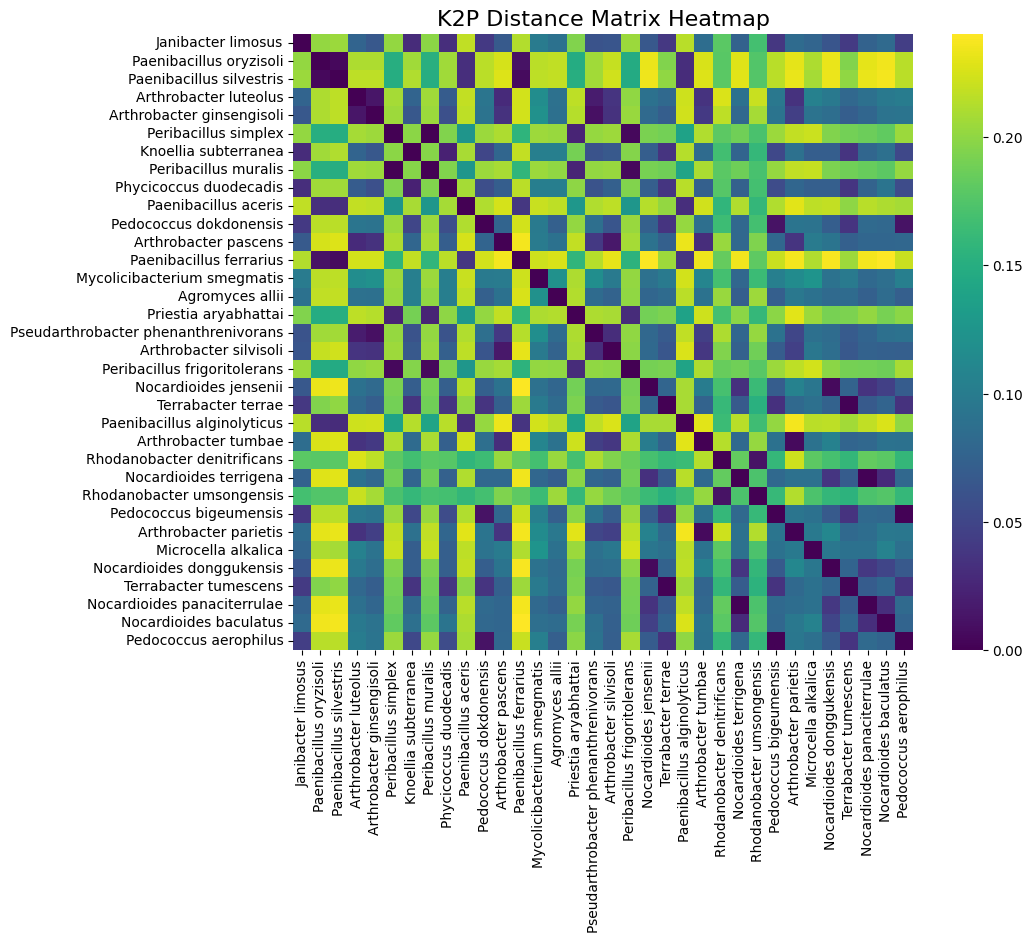

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(pairwise_distances_df, 
            # annot=True, 
            fmt=".3f", 
            cmap="viridis", 
            xticklabels=pairwise_distances_df.columns, 
            yticklabels=pairwise_distances_df.index)

plt.title("K2P Distance Matrix Heatmap", fontsize=16)
# plt.xlabel("Sequences")
# plt.ylabel("Sequences")
# plt.tight_layout()
plt.show()

In [14]:
# def is_valid_json(s):
#     try:
#         json.loads(s)
#         return True
#     except (ValueError, TypeError):
#         return False

# df["converted"] = df["result"].map(convert_json)

### Pairwise

In [38]:
pairwise_result_path = "analysis/results/arabidopsis/processed/pairwise.pkl"
# res, errors = get_scores_df_by_configuration_df("pairwise")
res = pd.read_pickle(pairwise_result_path)
res

,wanted_organism,unwanted_organism,initial_optimization_score_zscore_bulk_ratio,final_optimization_score_zscore_bulk_ratio,average_distance_score_zscore_bulk_ratio,average_distance_non_normalized_score_zscore_bulk_ratio,weakest_link_score_zscore_bulk_ratio,ratio_score_zscore_bulk_ratio,orf_optimization_cub_index_zscore_bulk_ratio,evaluation_score_zscore_bulk_ratio,...,final_optimization_score_single_diff,average_distance_score_single_diff,average_distance_non_normalized_score_single_diff,weakest_link_score_single_diff,ratio_score_single_diff,orf_optimization_cub_index_single_diff,evaluation_score_single_diff,run_time_single_diff,iterations_count_single_diff,final_sequence_single_diff
0,Agromyces allii,Arthrobacter luteolus,0.822131,1.049206,1.194508,0.165263,1.194508,1.140862,CAI,average_distance,...,None,0.632039,0.095155,0.632039,1.101303,CAI,average_distance,10.946126,1,ATGACCGATAGCCTTAATCTTTCCAGTTTATGGCCAGACTTGAGCT...
1,Agromyces allii,Nocardioides panaciterrulae,1.124537,1.073376,0.893233,0.075484,0.893233,1.163930,CAI,average_distance,...,None,0.398158,0.030213,0.398158,1.097942,CAI,average_distance,0.855591,1,ATGACCGATAGCCTTAATCTTTCCAGTTTATGGCCAGACTTGAGCA...
2,Agromyces allii,Nocardioides donggukensis,1.223519,1.076886,0.606917,0.074928,0.606917,1.102914,CAI,average_distance,...,None,0.226637,0.034618,0.226637,1.048152,CAI,average_distance,12.077380,1,ATGACCGATAGCCTTAATCTTTCCAGTTTATGGCCAGACTTGAGCA...
3,Agromyces allii,Nocardioides jensenii,0.811392,1.015025,0.599594,0.047381,0.599594,1.078668,CAI,average_distance,...,None,0.244923,0.017857,0.244923,1.055190,CAI,average_distance,3.201945,1,ATGACCGATAGCCTTAATCTTTCCAGTTTATGGCCAGACTTGAGCA...
4,Agromyces allii,Paenibacillus oryzisoli,0.734763,1.188781,7.686056,0.590208,7.686056,3.773800,CAI,average_distance,...,None,7.780231,0.612674,7.780231,3.176161,CAI,average_distance,0.643511,1,ATGACCGATAGCCTTAATCTTTCCAGTTTATGGCCAGACTTGAGCT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117,Mycolicibacterium smegmatis,Pedococcus aerophilus,1.012050,1.132195,1.816729,0.139412,1.816729,1.493486,CAI,average_distance,...,None,1.203620,0.094600,1.203620,1.459347,CAI,average_distance,0.241713,1,ATGACCGATAGCCTTAATCTTTCCAGTTTATGGCCAGACTTGAGCA...
1118,Mycolicibacterium smegmatis,Nocardioides terrigena,1.033338,1.116769,1.983707,0.108151,1.983707,1.319059,CAI,average_distance,...,None,1.161921,0.084976,1.161921,1.431600,CAI,average_distance,6.400993,1,ATGACCGATAGCCTTAATCTTTCCAGTTTATGGCCAGACTTGAGCA...
1119,Mycolicibacterium smegmatis,Pedococcus bigeumensis,1.026813,1.120494,1.661116,0.123258,1.661116,1.401582,CAI,average_distance,...,None,1.131908,0.087613,1.131908,1.409475,CAI,average_distance,13.096693,1,ATGACCGATAGCCTTAATCTTTCCAGTTTATGGCCAGACTTGAGCA...
1120,Mycolicibacterium smegmatis,Terrabacter terrae,0.869869,1.119769,2.000921,0.131590,2.000921,1.414678,CAI,average_distance,...,None,1.153382,0.084804,1.153382,1.426112,CAI,average_distance,0.023971,1,ATGACCGATAGCCTTAATCTTTCCAGTTTATGGCCAGACTTGAGCA...


In [35]:
res["organism_distance"] = res.apply(lambda row: pairwise_distances_df[row.wanted_organism][row.unwanted_organism], axis=1)

0.7485277128638151 4.718542974732091e-202


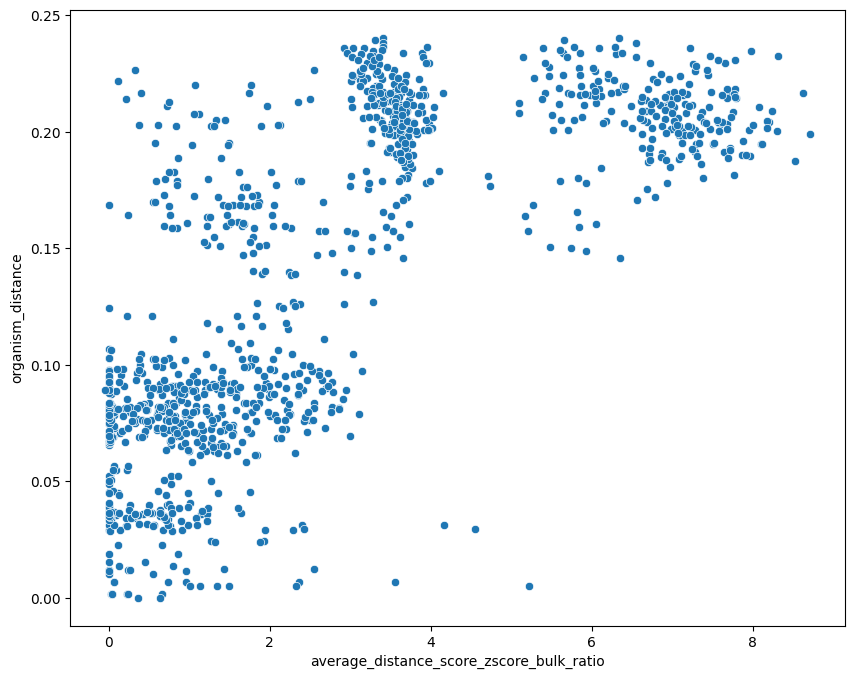

In [36]:
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(data=res[["average_distance_score_zscore_bulk_ratio", "organism_distance"]], x="average_distance_score_zscore_bulk_ratio", y="organism_distance")
r, p = stats.spearmanr(res["average_distance_score_zscore_bulk_ratio"], res["organism_distance"])
print(r, p)      

### One vs All

In [44]:
debug_res, errors = get_df_for_run_configuration("one_vs_all", "zscore_bulk_aa_diff", False)

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/arabidopsis/one_vs_all/zscore_bulk_aa_diff


In [45]:
errors[0]

{'error_message': "bad json string: 'evaluation'",
 'input': '{"configuration": ["/tamir2/moranb/microbiome/Igem_TAU_2021/analysis/example_data/arabidopsis/arabidopsis_microbiome/Nocardioides panaciterrulae.gbff", ["/tamir2/moranb/microbiome/Igem_TAU_2021/analysis/example_data/arabidopsis/arabidopsis_microbiome/Paenibacillus oryzisoli.gbff", "/tamir2/moranb/microbiome/Igem_TAU_2021/analysis/example_data/arabidopsis/arabidopsis_microbiome/Pseudarthrobacter phenanthrenivorans.gbff", "/tamir2/moranb/microbiome/Igem_TAU_2021/analysis/example_data/arabidopsis/arabidopsis_microbiome/Rhodanobacter umsongensis.gbff", "/tamir2/moranb/microbiome/Igem_TAU_2021/analysis/example_data/arabidopsis/arabidopsis_microbiome/Nocardioides terrigena.gbff", "/tamir2/moranb/microbiome/Igem_TAU_2021/analysis/example_data/arabidopsis/arabidopsis_microbiome/Knoellia subterranea.gbff", "/tamir2/moranb/microbiome/Igem_TAU_2021/analysis/example_data/arabidopsis/arabidopsis_microbiome/Nocardioides baculatus.gbff", "

In [42]:
one_vs_all_result_path = "analysis/results/arabidopsis/processed/one_vs_all.pkl"
res, errors = get_scores_df_by_configuration_df("one_vs_all")
# res = res.to_pickle(one_vs_all_result_path)

results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/arabidopsis/one_vs_all/zscore_bulk_aa_ratio
results dir is: /tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/arabidopsis/one_vs_all/zscore_bulk_aa_diff


ValueError: `dask.bag.Bag.to_dataframe` failed to properly infer metadata, please pass in metadata via the `meta` keyword